In [46]:
import os
import tensorflow as tf

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor) #Convert to Pillow Image


In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

(657, 1000, 3)


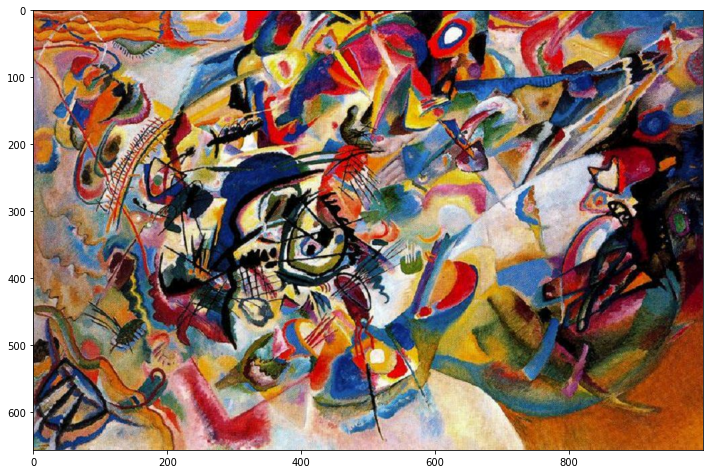

In [6]:
img = tf.io.read_file(style_path) 
# print(img)
img = tf.image.decode_image(img)
print(img.shape)
plt.imshow(img)

In [7]:
help(tf.cast)

Help on function cast in module tensorflow.python.ops.math_ops:

cast(x, dtype, name=None)
    Casts a tensor to a new type.
    
    The operation casts `x` (in case of `Tensor`) or `x.values`
    (in case of `SparseTensor` or `IndexedSlices`) to `dtype`.
    
    For example:
    
    >>> x = tf.constant([1.8, 2.2], dtype=tf.float32)
    >>> tf.dtypes.cast(x, tf.int32)
    <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>
    
    The operation supports data types (for `x` and `dtype`) of
    `uint8`, `uint16`, `uint32`, `uint64`, `int8`, `int16`, `int32`, `int64`,
    `float16`, `float32`, `float64`, `complex64`, `complex128`, `bfloat16`.
    In case of casting from complex types (`complex64`, `complex128`) to real
    types, only the real part of `x` is returned. In case of casting from real
    types to complex types (`complex64`, `complex128`), the imaginary part of the
    returned value is set to `0`. The handling of complex types here matches the
    behav

In [8]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img) #Reads and outputs the entire contents of the input filename.
#  Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input 
# bytes `string` into a `Tensor`of type `dtype`.
    img = tf.image.decode_image(img, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32)
    print(img.shape)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    print('shape',shape)
    # Ensures that any dimension greater than 512 is subjected to be 512
    long_dim = max(shape)
    print('long_dim',long_dim)
    scale = max_dim / long_dim
    print('scale: ',scale)
    new_shape = tf.cast(shape * scale, tf.int32)
    print('new shape: ',new_shape)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [9]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


In [10]:
content_image = load_img(content_path)
style_image = load_img(style_path)


(577, 700, 3)
shape tf.Tensor([577. 700.], shape=(2,), dtype=float32)
long_dim tf.Tensor(700.0, shape=(), dtype=float32)
scale:  tf.Tensor(0.73142856, shape=(), dtype=float32)
new shape:  tf.Tensor([422 512], shape=(2,), dtype=int32)
(657, 1000, 3)
shape tf.Tensor([ 657. 1000.], shape=(2,), dtype=float32)
long_dim tf.Tensor(1000.0, shape=(), dtype=float32)
scale:  tf.Tensor(0.512, shape=(), dtype=float32)
new shape:  tf.Tensor([336 512], shape=(2,), dtype=int32)


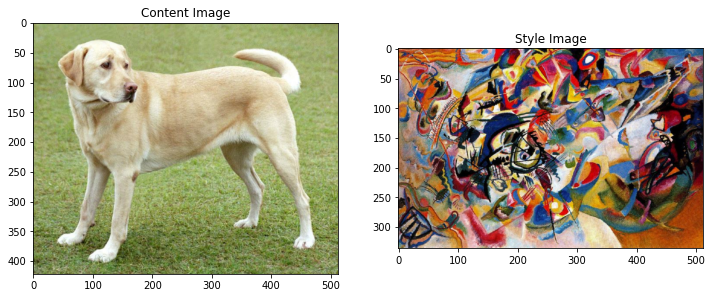

In [11]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


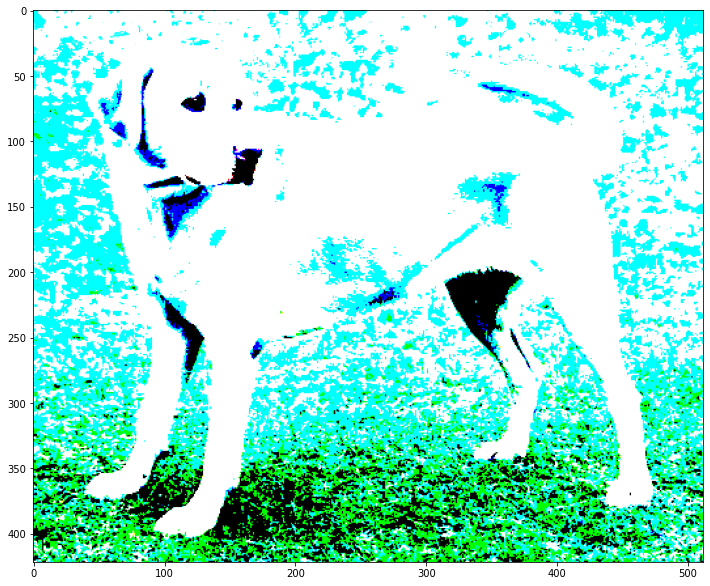

In [12]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
plt.imshow(x[0,:,:,:])

In [13]:
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')


In [14]:
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [15]:
# Decoding the predictions based on the probabilities 
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646086)]

In [16]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)



input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [17]:
# Choose intermediate layers from the network to represent the style and content of the image:

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [18]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
    vgg.trainable = False #Setting to false because freezing weight parameters for transfer learning
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [19]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)


In [20]:
#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



In [21]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #batch matrix muliplication
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


In [22]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers) # passing all the layers to the model
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
        
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
#The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}


In [23]:
help(tf.keras.applications.vgg19.preprocess_input)

Help on function preprocess_input in module tensorflow.python.keras.applications.vgg19:

preprocess_input(x, data_format=None)
    Preprocesses a tensor or Numpy array encoding a batch of images.
    
    Usage example with `applications.MobileNet`:
    
    ```python
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet()
    x = core(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    image = tf.image.decode_png(tf.io.read_file('file.png'))
    result = model(image)
    ```
    
    Arguments:
      x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
        channels, with values in the range [0, 255].
        The preprocessed data are written over the input data
        if the data types are compatible. To avoid this
        behaviour, `numpy.copy(x)` can be used.
      data_format: Optional data format of 

In [26]:
extractor = StyleContentModel(style_layers, content_layers) # Creating the model for the neural style transfer
results = extractor(tf.constant(content_image))


In [27]:
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.555
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


In [30]:
style_targets = extractor(style_image)['style'] #Returns the style dictionary 
content_targets = extractor(content_image)['content'] #Return the content dictionary in function call 


In [33]:
# To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image
image = tf.Variable(content_image) #Contains the image to optimize 


In [34]:
def clip_0_1(image): #Keep the values in the image between 0 and 1
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [35]:
#  Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [36]:
# Weights for the total loss alpha and beta
style_weight=1e-2
content_weight=1e4

In [37]:
# calculating the mean square error for your image's output relative to each target, 
# then take the weighted sum of these losses.
def style_content_loss(outputs):
    style_outputs = outputs['style'] #From the style_content model
    content_outputs = outputs['content']
#     style_targets is from the model with the style image as input
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [38]:
@tf.function()
#  tensors are evaluated immediately, you don't have a graph to calculate gradients and so you need a gradient tape.
def train_step(image): #train the generated image
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image) #compute gradient
    opt.apply_gradients([(grad, image)]) #An `Operation` that applies the specified gradients. The `iterations` will be automatically increased by 1.
    image.assign(clip_0_1(image))


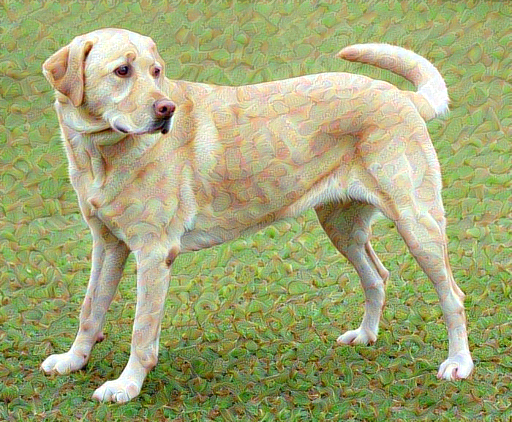

In [39]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)


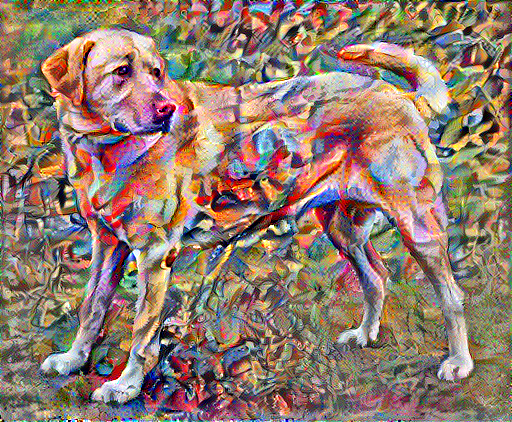

Train step: 1000
Total time: 52.6


In [42]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


In [45]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     